In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

## First, we run the finbert using the precleaned data and the pretrained model

In [628]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

# testing the pipeline
sentences = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]
results = nlp(sentences)
print(results)  #LABEL_0: neutral; LABEL_1: positive; LABEL_2: negative

Downloading:   0%|          | 0.00/533 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/439M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

[{'label': 'Negative', 'score': 0.9966173768043518}, {'label': 'Positive', 'score': 1.0}, {'label': 'Negative', 'score': 0.9999710321426392}, {'label': 'Neutral', 'score': 0.9889441728591919}]


In [626]:
df_ca_cleaned = pd.read_csv("../data/dataset/SentimentData/sent_can_clean.csv")
df_ca_cleaned = df_ca_cleaned.loc[:, df_ca_cleaned.columns != 'Unnamed: 0']
df_us_cleaned = pd.read_csv("../data/dataset/SentimentData/sent_usa_clean.csv")
df_us_cleaned = df_us_cleaned.loc[:, df_us_cleaned.columns != 'Unnamed: 0']
df_us_cleaned['new_contents'] = df_us_cleaned['new_contents'].apply(lambda x: x.replace('[', '').replace('\xa0&', '').replace('Section','').replace(']', '').replace('\\r', ' ').replace("\', \'", '').replace('SECTION',''))
df_ca_cleaned['new_contents'] = df_ca_cleaned['new_contents'].apply(lambda x: x.replace('[', '').replace('\xa0&', '').replace('Section','').replace(']', '').replace('\\r', ' ').replace("\', \'", '').replace('SECTION',''))

In [653]:
def seperate(x):
    '''
    Seperates the string of text data to a list of strings where each string with length smaller than 512.
    512 is the maximum taken FinBert can take per run.

    Parameters:
        x (string): The raw text

    Returns:
        res (list): list of the seperated string
    '''
    res = []
    num_parts = int(len(x) / 511 + 1)
    start_idx = 0
    end_idx = 511
    for i in range(num_parts):
        res.append(x[start_idx:end_idx])
        start_idx += 511
        end_idx += 511
        if end_idx >= len(x):
            end_idx = len(x)
    return res

def calc_sentiment_score(x):
    '''
    Calculates the total sentiment score using the sentiments calculated from each segment strings within the list seperate above.

    Parameters:
        x (list): list of dictionary produced by FinBert

    Returns:
        res (float): final sentiment score of that meeting
    '''    
    res = 0
    for i in x:
        if i['label'] == 'Positive':
            rate = 1 * i['score']
            res += rate
        elif i['label'] == 'Neutral':
            rate = 0.1 * i['score']
            res += rate
        else:
            rate = -1 * i['score']
            res += rate
    res /= len(x)
    return res

In [642]:
# bert only allows character of 512, so we split it and weight it later
df_us_cleaned['new_contents'] = df_us_cleaned['new_contents'].apply(lambda x: seperate(x))
df_ca_cleaned['new_contents'] = df_ca_cleaned['new_contents'].apply(lambda x: seperate(x))

In [645]:
# run fin bert model
df_us_cleaned['sentiments'] = df_us_cleaned['new_contents'].apply(lambda x: nlp(x))
df_us_cleaned['sentiment_score'] = df_us_cleaned['sentiments'].apply(lambda x: calc_sentiment_score(x))
df_ca_cleaned['sentiments'] = df_ca_cleaned['new_contents'].apply(lambda x: nlp(x))
df_ca_cleaned['sentiment_score'] = df_ca_cleaned['sentiments'].apply(lambda x: calc_sentiment_score(x))

## Reading Data
Below we list the data we used
- Market data
1. the FX rate USDCAD (source: Polyfinance)
2. Market Info of FXUSDCAD: High Low Volume (source: Bloomberg)
3. Realized volatility of FXUSDCAD (source: Bloomberg)
4. ATM Implied volatility of FXUSDCAD (source: Bloomberg)
5. Forward implied yield of FXUSDCAD (source: Bloomberg)
6. GARCH Vol of FXUSDCAD (source: Bloomberg)
7. Forward price of FX rate USDCAD (source: Bloomberg)
8. SP500 (source: YahooFinance)
9. S&P/TSX (source: YahooFinance)
10. VIX index (source: CBOE)
11. S&P/TSX VIX Canada (source: S&P Global)

- MacroEconomic Data
1. CPI\
a. Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (source: Fred) \
b. Core PCE excluding Food and Energy, Monthly (source: Fred) \
c. Canada CPI (source: Fred)

2. Interest Rate\
a. Fed Rate (source: Fred) \
b. T-bill US (source: Fred) \
c. T-bill CA (source: Canada Bank) \
d. GDP CA (source: Fred) \
e. GDP US (source: Fred) 

3. Sales\
a. US Advance Real Retail and Food Services Sales, monthly (source: Fred) \
b. US New Home Sales, monthly (source: Fred) 

4. US Economic Index \
a. US bank prime rate (Source: CanBankValetApi) \
b. US weekly econ index (Source: Fed Reserve NY)
c. US recession prob (Source: Fred)
d. US inflation rate (Source: Fred)
e. US expected inflation (Source: Fred)
f. US WTI oil price (Source: Fred)
g. US Commodity Index (Source: Yahoo Finance)

5. CA Economic Index (Source: CanBankValetApi)\
a. Weekly Bank of Canada commodity price index. \
b. Crude oil component weights \
c. CA bank prime rate (Source: CanBankValetApi)

6. EU Economic Index (Source: PolyFinance)\
a. EUR Foreign FX index price matrix

7. OCDE Economic Index (Source: PolyFinance)\
a. OCDE for US \
b. OCDE for CA 

8. Employment and Unemployment Rate (Source: Fred)\
a. Unemployment rate of US \
b. Employment rate of US \
c. Unemployment rate of CA

9. M2 (Source: Fred)\
a. M2 of US

10. ISM index (Source: Fred)\
a. ISM Purchasing Managers Index \
b. ISM Non-manufacturing Index

In [440]:
class LoadingData:
    """Class designed for loading data described above"""
    def __init__(self):
        '''
        Initiates the class and runs the class.

        Global Parameters in self:
            list_df_Mkt_data (list): list of pandas datasets with initial cleaned market data
            list_df_Econ_data (list): list of pandas datasets with initial cleaned economic data
        '''
        print("="*30)
        print("Start Loading Data ... ")
        self.list_df_Mkt_data, self.list_df_Econ_data = self.read_and_rename_data()
        print("Finished Loading Data")
    
    def read_and_rename_data(self):
        '''
        Reads-in and renaming the columns, this function also unify the time to dt64ns.

        Returns:
            list_df_Mkt_data (list): list of pandas datasets with initial cleaned market data
            list_df_Econ_data (list): list of pandas datasets with initial cleaned economic data
        '''
        # market data
        df_FXUSDCAD = pd.read_csv("../data/dataset/MarketData/FXUSDCAD.csv")  # FXUSDCAD
        df_FXUSDCAD['date'] = pd.to_datetime(df_FXUSDCAD['date'], format='%Y-%m-%d')
        
        df_FXUSDCADMkt = pd.read_csv("../data/dataset/MarketData/USD_CAD Historical Data.csv")  # additional market info of FXUSDCAD
        df_FXUSDCADMkt['Date'] = pd.to_datetime(df_FXUSDCADMkt['Date'], format='%m/%d/%Y')
        df_FXUSDCADMkt = df_FXUSDCADMkt[df_FXUSDCADMkt['Date'] >= '2016-12-30'].rename({'Date':'date'}, axis='columns')
        df_FXUSDCADMkt['Vol.'] = df_FXUSDCADMkt['Vol.'].apply(lambda x: float(x.replace('K', '')) * 1000 if pd.notnull(x) else x)
        df_FXUSDCADMkt['Change %'] = df_FXUSDCADMkt['Change %'].apply(lambda x: float(x.replace('%', '')) / 100 if pd.notnull(x) else x)
        
        df_Bb_FXUSDCAD_Fwd1W = pd.read_excel("../data/dataset/MarketData/Bloomberg_CAD1W.xlsx")  # 1W forward price of FXUSDCAD
        df_Bb_FXUSDCAD_Fwd1W['Dates'] = pd.to_datetime(df_Bb_FXUSDCAD_Fwd1W['Dates'], format='%Y-%m-%d')
        df_Bb_FXUSDCAD_Fwd1W = df_Bb_FXUSDCAD_Fwd1W[['Dates', 'Mid Price']].rename({'Dates': 'date', 'Mid Price': 'FXUSDCAD_Fwd1W'}, axis='columns')
        
        df_Bb_FXUSDCAD_Fwd2W = pd.read_excel("../data/dataset/MarketData/Bloomberg_CAD2W.xlsx")  # 2W forward price of FXUSDCAD
        df_Bb_FXUSDCAD_Fwd2W['Dates'] = pd.to_datetime(df_Bb_FXUSDCAD_Fwd2W['Dates'], format='%Y-%m-%d')
        df_Bb_FXUSDCAD_Fwd2W = df_Bb_FXUSDCAD_Fwd2W[['Dates', 'Mid Price']].rename({'Dates': 'date', 'Mid Price': 'FXUSDCAD_Fwd2W'}, axis='columns')

        df_Bb_FXUSDCAD_Fwd1M = pd.read_excel("../data/dataset/MarketData/Bloomberg_CAD1M.xlsx")  # 1M forward price of FXUSDCAD
        df_Bb_FXUSDCAD_Fwd1M['Dates'] = pd.to_datetime(df_Bb_FXUSDCAD_Fwd1M['Dates'], format='%Y-%m-%d')
        df_Bb_FXUSDCAD_Fwd1M = df_Bb_FXUSDCAD_Fwd1M[['Dates', 'Mid Price']].rename({'Dates': 'date', 'Mid Price': 'FXUSDCAD_Fwd1M'}, axis='columns')
        
        df_Bb_FXUSDCAD_Vol_Yld_DeltaRR = pd.read_excel("../data/dataset/MarketData/Bloomberg_Vol_YLD_FXUSDCAD.xlsx")  # Vol, Fwd yield and Delta risk reversal of FXUSDCAD
        df_Bb_FXUSDCAD_Vol_Yld_DeltaRR['Dates'] = pd.to_datetime(df_Bb_FXUSDCAD_Vol_Yld_DeltaRR['Dates'], format='%Y-%m-%d')
        df_Bb_FXUSDCAD_Vol_Yld_DeltaRR = df_Bb_FXUSDCAD_Vol_Yld_DeltaRR.rename({'Dates': 'date'}, axis='columns')
        
        df_SP5 = pd.read_excel("../data/dataset/MarketData/SP5.xlsx")  # SP500 index
        df_SP5['Date'] = pd.to_datetime(df_SP5['Date'], format='%Y-%m-%d')
        df_SP5 = df_SP5[['Date', 'Adj Close']].rename({'Date': 'date', 'Adj Close': 'SP5'}, axis='columns')
        
        df_SP5_TSX = pd.read_csv("../data/dataset/MarketData/^GSPTSE.csv")  # S&P/TSX index
        df_SP5_TSX['Date'] = pd.to_datetime(df_SP5_TSX['Date'], format='%m/%d/%Y')
        df_SP5_TSX = df_SP5_TSX[['Date', 'Adj Close']].rename({'Date': 'date', 'Adj Close': 'S&P/TSX'}, axis='columns')
        
        df_VIX = pd.read_csv("../data/dataset/MarketData/CBOE Volatility Index Historical Data.csv")  # VIX
        df_VIX['Date'] = pd.to_datetime(df_VIX['Date'], format='%Y-%m-%d')
        df_VIX = df_VIX[df_VIX['Date'] >= '2016-12-30'][['Date', 'Price']].rename({'Date': 'date', 'Price': 'US_VIX'}, axis='columns')
        df_VIX = df_VIX[::-1].reset_index().drop(['index'], axis=1)

        df_VIX_CA = pd.read_csv("../data/dataset/MarketData/VIX_Canada.csv")  # VIX CA
        df_VIX_CA['date'] = pd.to_datetime(df_VIX_CA['date'], format='%m/%d/%Y')
        df_VIX_CA = df_VIX_CA.rename({'S&P/TSX 60 VIX Index (CAD)': 'CA_VIX'}, axis='columns')
        
        list_df_Mkt_data = [df_FXUSDCAD, df_FXUSDCADMkt, df_Bb_FXUSDCAD_Fwd1W, df_Bb_FXUSDCAD_Fwd2W, df_Bb_FXUSDCAD_Fwd1M, 
                           df_Bb_FXUSDCAD_Vol_Yld_DeltaRR, df_SP5, df_SP5_TSX, df_VIX, df_VIX_CA]

        # MacroEcon Data
        ## CPI
        df_CPIAUCSL = pd.read_csv("../data/dataset/MacroEconData/CPI/FRED_CPIAUCSL.csv")  # CPI of US
        df_CPIAUCSL['date'] = pd.to_datetime(df_CPIAUCSL['Date'], format='%Y-%m-%d')
        df_CPIAUCSL = df_CPIAUCSL[['date', 'Value']].rename({'Value': 'CPIAUCSL'}, axis='columns')
        
        df_PCEPILFE = pd.read_csv("../data/dataset/MacroEconData/CPI/FRED_PCEPILFE.csv")  # Core PCE of USD
        df_PCEPILFE['date'] = pd.to_datetime(df_PCEPILFE['Date'], format='%Y-%m-%d')
        df_PCEPILFE = df_PCEPILFE[['date', 'Value']].rename({'Value': 'PCEPILFE'}, axis='columns')
        
        df_CACPI = pd.read_excel("../data/dataset/MacroEconData/CPI/CPICA.xls")  # CPI of CA
        df_CACPI['date'] = pd.to_datetime(df_CACPI['observation_date'], format='%Y-%m-%d')
        df_CACPI = df_CACPI[df_CACPI['date']>= '2016-12-30'][['date', 'CPALCY01CAM661N']].rename({'CPALCY01CAM661N': 'CA_CPI'}, axis='columns')
        
        ## Interest rate
        df_DFEDTARL = pd.read_csv("../data/dataset/MacroEconData/InterestRate/Fed/FRED_DFEDTARL.csv")  # Target Lower FED Rate
        df_DFEDTARL['date'] = pd.to_datetime(df_DFEDTARL['Date'], format='%Y-%m-%d')
        df_DFEDTARL = df_DFEDTARL[['date', 'Value']].rename({'Value': 'DFEDTARL'}, axis='columns')
        
        df_DFEDTARU = pd.read_csv("../data/dataset/MacroEconData/InterestRate/Fed/FRED_DFEDTARU.csv")  # Target Upper FED Rate
        df_DFEDTARU['date'] = pd.to_datetime(df_DFEDTARU['Date'], format='%Y-%m-%d')
        df_DFEDTARU = df_DFEDTARU[['date', 'Value']].rename({'Value': 'DFEDTARU'}, axis='columns')
        
        df_DFF = pd.read_csv("../data/dataset/MacroEconData/InterestRate/Fed/FRED_DFF.csv")  # Effective FED Rate
        df_DFF['date'] = pd.to_datetime(df_DFF['Date'], format='%Y-%m-%d')
        df_DFF = df_DFF[['date', 'Value']].rename({'Value': 'DFF'}, axis='columns')
        
        df_USTBill = pd.read_csv("../data/dataset/MacroEconData/InterestRate/TreasuryBill/USTREASURY_YIELD.csv")  # US T-yield
        df_USTBill['Date'] = pd.to_datetime(df_USTBill['Date'], format='%Y-%m-%d')
        df_USTBill = df_USTBill.rename({**{'Date': 'date'}, **{i: "US_Tbill_" + i.replace(' ', '_') for i in df_USTBill.columns[1:]}}, axis='columns')
        
        df_CATBill = pd.read_csv("../data/dataset/MacroEconData/InterestRate/TreasuryBill/CATREASURY_YIELD.csv")  # CA T-yield
        df_CATBill['date'] = pd.to_datetime(df_CATBill['date'], format='%m/%d/%Y')
        df_CATBill = df_CATBill.dropna()
        df_CATBill = df_CATBill[df_CATBill['date']>= '2016-12-30'].rename({i: "CA_Tbill_" + i for i in df_CATBill.columns[1:]}, axis='columns')
        
        ## GDP
        df_CAGDP_Real = pd.read_excel("../data/dataset/MacroEconData/GDP/GDPCA.xls")  # CA Real GDP
        df_CAGDP_Real['date'] = pd.to_datetime(df_CAGDP_Real['observation_date'], format='%Y-%m-%d')
        df_CAGDP_Real = df_CAGDP_Real[['date', 'NAEXKP01CAQ189S']].rename({'NAEXKP01CAQ189S': 'CA_RGDP'}, axis='columns')
        
        df_USGDP_Real = pd.read_csv("../data/dataset/MacroEconData/GDP/FRED_GDPC1.csv")  # US Real GDP
        df_USGDP_Real['date'] = pd.to_datetime(df_USGDP_Real['Date'], format='%m/%d/%Y')
        df_USGDP_Real = df_USGDP_Real[['date', 'Value']].rename({'Value': 'US_RGDP'}, axis='columns')
        
        df_USGDP_Potential = pd.read_csv("../data/dataset/MacroEconData/GDP/FRED_GDPPOT.csv")  # US Potential GDP
        df_USGDP_Potential['date'] = pd.to_datetime(df_USGDP_Potential['Date'], format='%Y-%m-%d')
        df_USGDP_Potential = df_USGDP_Potential[['date', 'Value']].rename({'Value': 'US_PGDP'}, axis='columns')        
        
        ## Sales
        df_US_Sales_RetailFood = pd.read_csv("../data/dataset/MacroEconData/Sales/FRED_HSN1F.csv")  # US Retail and Food Services Sales
        df_US_Sales_RetailFood['date'] = pd.to_datetime(df_US_Sales_RetailFood['Date'], format='%Y-%m-%d')
        df_US_Sales_RetailFood = df_US_Sales_RetailFood[['date', 'Value']].rename({'Value': 'US_Sales_RetailFood'}, axis='columns')        
        
        df_US_Sales_House = pd.read_csv("../data/dataset/MacroEconData/Sales/FRED_RRSFS.csv")  # US New Home Sales
        df_US_Sales_House['date'] = pd.to_datetime(df_US_Sales_House['Date'], format='%Y-%m-%d')
        df_US_Sales_House = df_US_Sales_House[['date', 'Value']].rename({'Value': 'US_Sales_House'}, axis='columns')        
        
        ## Economic Index US
        df_US_int_rate = pd.read_csv("../data/dataset/MacroEconData/EconomicIndexUs/U.S.-interest_rate.csv")  # US interest rate
        df_US_int_rate['date'] = pd.to_datetime(df_US_int_rate['date'], format='%Y-%m-%d')
        df_US_int_rate = df_US_int_rate[df_US_int_rate['date'] >= '2016-12-30'][['date', 'V121820']].rename({'V121820': 'US_Bank_Prime_rate'}, axis='columns')
        
        df_US_economic_idx = pd.read_excel(pd.ExcelFile("../data/dataset/MacroEconData/EconomicIndexUs/weekly-economic-index_Datathon.xlsx"), "Weekly Economic Index")  # US weekly econ index
        df_US_economic_idx['date'] = pd.to_datetime(df_US_economic_idx['Date'], format='%m/%d/%Y')
        df_US_economic_idx = df_US_economic_idx[df_US_economic_idx['date'] >= "2016-12-30"][['date', 'WEI']].rename({'WEI': 'US_WEI'})
        
        df_US_recession_prob = pd.read_excel(pd.ExcelFile("../data/dataset/MacroEconData/EconomicIndexUs/weekly-economic-index_Datathon.xlsx"), "Recession Proability")  # US Recession Proability
        df_US_recession_prob['date'] = pd.to_datetime(df_US_recession_prob['observation_date'], format='%Y-%m-%d')
        df_US_recession_prob = df_US_recession_prob[df_US_recession_prob['date'] >= "2016-12-30"][['date', 'RECPROUSM156N']].rename({'RECPROUSM156N': 'US_Rec_Prob'}, axis='columns')
        
        df_US_inflation = pd.read_excel(pd.ExcelFile("../data/dataset/MacroEconData/EconomicIndexUs/weekly-economic-index_Datathon.xlsx"), "US Inflation")  # US Inflation
        df_US_inflation['date'] = pd.to_datetime(df_US_inflation['observation_date'], format='%Y-%m-%d')
        df_US_inflation = df_US_inflation[df_US_inflation['date'] >= "2016-12-30"][['date', 'Inflarion']].rename({'Inflarion': 'US_Inflation'}, axis='columns')
        
        df_US_inflation_expct = pd.read_excel(pd.ExcelFile("../data/dataset/MacroEconData/EconomicIndexUs/weekly-economic-index_Datathon.xlsx"), "US Inflation Expectation")  # US Inflation Expectation
        df_US_inflation_expct['date'] = pd.to_datetime(df_US_inflation_expct['observation_date'], format='%Y-%m-%d')
        df_US_inflation_expct = df_US_inflation_expct[df_US_inflation_expct['date'] >= "2016-12-30"][['date', 'MICH']].rename({'MICH': 'US_Inflation_Expct'}, axis='columns')
        
        df_US_Oil_Price = pd.read_excel(pd.ExcelFile("../data/dataset/MacroEconData/EconomicIndexUs/weekly-economic-index_Datathon.xlsx"), "Oil Price")  # US Oil Price
        df_US_Oil_Price['date'] = pd.to_datetime(df_US_Oil_Price['observation_date'], format='%Y-%m-%d')
        df_US_Oil_Price = df_US_Oil_Price[df_US_Oil_Price['date'] >= "2016-12-30"][['date', 'DCOILWTICO']].rename({'DCOILWTICO': 'US_WTI_Oil_Price'}, axis='columns')
        
        df_US_Commodity_Idx = pd.read_excel(pd.ExcelFile("../data/dataset/MacroEconData/EconomicIndexUs/weekly-economic-index_Datathon.xlsx"), "Commodity Index")  # US Commodity Index
        df_US_Commodity_Idx['date'] = pd.to_datetime(df_US_Commodity_Idx['Date'], format='%m/%d/%Y')
        df_US_Commodity_Idx = df_US_Commodity_Idx[df_US_Commodity_Idx['date'] >= "2016-12-30"][['date', 'Adj Close']].rename({'Adj Close': 'US_Commodity_Idx'}, axis='columns')
        
        ## Economic Index CA
        df_CA_int_rate = pd.read_csv("../data/dataset/MacroEconData/EconomicIndexCa/CA.-interest_rate.csv")  # CA bank prime rate
        df_CA_int_rate['date'] = pd.to_datetime(df_CA_int_rate['date'], format='%Y-%m-%d')
        df_CA_int_rate = df_CA_int_rate[df_CA_int_rate['date'] >= "2016-12-30"][['date', 'V39078']].rename({'V39078': 'CA_Bank_Prime_rate'}, axis='columns')
        
        df_CA_BCPI_commodity = pd.read_csv("../data/dataset/MacroEconData/EconomicIndexCa/BCPI_WEEKLY.csv")  # Weekly Bank of Canada commodity price index
        df_CA_BCPI_commodity['date'] = pd.to_datetime(df_CA_BCPI_commodity['date'], format='%m/%d/%Y')
        df_CA_BCPI_commodity = df_CA_BCPI_commodity[df_CA_BCPI_commodity['date'] >= "2016-12-30"].rename({i: "CA_" + i for i in df_CA_BCPI_commodity.columns[1:]}, axis='columns')
        
        df_CA_BCPI_crude_oil = pd.read_csv("../data/dataset/MacroEconData/EconomicIndexCa/Crude_Oil_Component_Weights.csv")  # Weekly Bank of Canada crude oil component price index
        df_CA_BCPI_crude_oil = df_CA_BCPI_crude_oil[:-4]
        df_CA_BCPI_crude_oil['date'] = pd.to_datetime(df_CA_BCPI_crude_oil['date'], format='%m/%d/%Y')
        df_CA_BCPI_crude_oil = df_CA_BCPI_crude_oil[df_CA_BCPI_crude_oil['date'] >= "2016-12-30"].rename({i: "CA_" + i for i in df_CA_BCPI_crude_oil.columns[1:]}, axis='columns')
        
        ## Economic Index EU
        df_EU_FX_priceMatrix = pd.read_csv("../data/dataset/MacroEconData/EconomicIndexEuro/FXEURFOREIGN.csv")  # EUR Foreign FX index price matrix
        df_EU_FX_priceMatrix['date'] = pd.to_datetime(df_EU_FX_priceMatrix['Date'], format='%Y-%m-%d')
        df_EU_FX_priceMatrix = df_EU_FX_priceMatrix[df_EU_FX_priceMatrix['date'] >= "2016-12-30"][['date', 'USD', 'CAD']].rename({'USD': 'FXEURUSD', 'CAD': 'FXEURCAD'}, axis='columns')
        df_EU_FX_priceMatrix = df_EU_FX_priceMatrix[::-1]
        
        ## Economic Index OCDE
        df_CA_OCDE = pd.read_excel(pd.ExcelFile("../data/dataset/MacroEconData/EconomicIndexOCDE/Weekly_Tracker_OCDE.xlsx"), "Canada")  # OCDE of CA
        df_CA_OCDE['date'] = pd.to_datetime(df_CA_OCDE['date'], format='%Y-%m-%d')
        df_CA_OCDE = df_CA_OCDE.rename({i: "CA_OCDE_" + i for i in df_CA_OCDE.columns[1:]}, axis='columns')
        
        df_US_OCDE = pd.read_excel(pd.ExcelFile("../data/dataset/MacroEconData/EconomicIndexOCDE/Weekly_Tracker_OCDE.xlsx"), "United States")  # OCDE of US
        df_US_OCDE['date'] = pd.to_datetime(df_US_OCDE['date'], format='%Y-%m-%d')
        df_US_OCDE = df_US_OCDE.rename({i: "US_OCDE_" + i for i in df_US_OCDE.columns[1:]}, axis='columns')
        
        ## Employment
        df_US_unemploy = pd.read_csv("../data/dataset/MacroEconData/Employment/FRED_UNRATE.csv")  # Unemployment rate of US
        df_US_unemploy['date'] = pd.to_datetime(df_US_unemploy['Date'], format='%Y-%m-%d')
        df_US_unemploy = df_US_unemploy[['date', 'Value']].rename({'Value': 'US_Unemp'}, axis='columns')
        
        df_US_employ = pd.read_csv("../data/dataset/MacroEconData/Employment/FRED_PAYEMS.csv")  # Employment rate of US
        df_US_employ['date'] = pd.to_datetime(df_US_employ['Date'], format='%Y-%m-%d')
        df_US_employ = df_US_employ[['date', 'Value']].rename({'Value': 'US_Emp'}, axis='columns')
        
        df_CA_unemploy = pd.read_excel("../data/dataset/MacroEconData/Employment/UnemrateCA.xls")  # Unmployment rate of CA
        df_CA_unemploy['date'] = pd.to_datetime(df_CA_unemploy['observation_date'], format='%Y-%m-%d')
        df_CA_unemploy = df_CA_unemploy[1:][['date', 'LRUNTTTTCAM156S']].rename({'LRUNTTTTCAM156S': 'CA_Unemp'}, axis='columns')
        
        ## M2
        df_US_M2 = pd.read_excel("../data/dataset/MacroEconData/M2/M2US.xls")  # M2 of US
        df_US_M2['date'] = pd.to_datetime(df_US_M2['observation_date'], format='%Y-%m-%d')
        df_US_M2 = df_US_M2[['date', 'WM2NS']].rename({'WM2NS': 'US_M2'}, axis='columns')
        
        ## ISM
        df_ISM_NonMan = pd.read_csv("../data/dataset/MacroEconData/ISM/ISM_NONMAN_NMI.csv")  # ISM Non-manufacturing Index
        df_ISM_NonMan['date'] = pd.to_datetime(df_ISM_NonMan['Date'], format='%Y-%m-%d')
        df_ISM_NonMan = df_ISM_NonMan[['date', 'Index']].rename({'Index': 'ISM_NonManufactureIdx'}, axis='columns')
        
        df_ISM_Man = pd.read_csv("../data/dataset/MacroEconData/ISM/ISM_MAN_PMI.csv")  # ISM Purchasing Managers Index
        df_ISM_Man['date'] = pd.to_datetime(df_ISM_Man['Date'], format='%Y-%m-%d')
        df_ISM_Man = df_ISM_Man[['date', 'PMI']].rename({'PMI': 'ISM_PurchaseManagerIdx'}, axis='columns')
        
        list_df_Econ_data = [df_CPIAUCSL, df_PCEPILFE, df_CACPI, df_DFEDTARL, df_DFEDTARU, df_DFF, df_USTBill, df_CATBill,
                            df_CAGDP_Real, df_USGDP_Real, df_USGDP_Potential, df_US_Sales_RetailFood, df_US_Sales_House,
                            df_US_int_rate, df_US_economic_idx, df_US_recession_prob, df_US_inflation, df_US_inflation_expct,
                            df_US_Oil_Price, df_US_Commodity_Idx, df_CA_int_rate, df_CA_BCPI_commodity, df_CA_BCPI_crude_oil,
                            df_EU_FX_priceMatrix, df_CA_OCDE, df_US_OCDE, df_US_unemploy, df_US_employ, df_CA_unemploy,
                            df_US_M2, df_ISM_NonMan, df_ISM_Man]
        
        return list_df_Mkt_data, list_df_Econ_data

In [229]:
class Utilities:
    """Some utilities for data wragling."""
    def __init__(self):
        """Initiates the class"""
        pass
    
    def merge_df(self, df_list):
        '''
        Out merges all the pd dataframe within the list.

        Parameters:
            df_list (list): list of pd dataframe

        Returns:
            temp_df (pd.DataFrame): pandas dataframe after merge
        '''
        temp_df = df_list[0]
        temp_shape = temp_df.shape[1]
        # print(temp_shape)
        for i in range(1, len(df_list)):
            # print("="*30)
            # print("shape before merge: ", temp_df.shape)
            # print("added df shape: ", df_list[i].shape)
            # temp_shape += df_list[i].shape[1] - 1
            temp_df = temp_df.merge(df_list[i], on='date', how='outer')
            # print("shape after merge: ", temp_df.shape)
            # if temp_shape != temp_df.shape[1]:
                # print(123)
        return temp_df
    
    def percent_missing(self, df):
        '''
        Computes percentage missing in each column of the dataframe.

        Parameters:
            df (pd.DataFrame): pd dataframe

        Returns:
            dict_x (dict): information of missing values in a dictionary
        '''
        data = pd.DataFrame(df)
        df_cols = list(pd.DataFrame(data))
        dict_x = {}
        for i in range(0,len(df_cols)):
            dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean() * 100, 2)})
        return dict_x

In [441]:
RawData = LoadingData()

Start Loading Data ... 
Finished Loading Data


In [232]:
Utilities = Utilities()

In [442]:
data_mkt_total = Utilities.merge_df(RawData.list_df_Mkt_data)
data_econ_total = Utilities.merge_df(RawData.list_df_Econ_data)
data_total = data_mkt_total.merge(data_econ_total, on='date', how='outer')
data_total = data_total.sort_values(by='date')
data_total = data_total.reset_index().drop(['index'], axis=1)

In [443]:
# here we split the label of each dataframe according to its time frequency
label_daily = ['FXUSDCAD', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'FXUSDCAD_Fwd1W', 'FXUSDCAD_Fwd2W',
              'FXUSDCAD_Fwd1M', 'USDCADV1W Curncy', 'USDCADV2W Curncy', 'USDCADV1M BGN Curncy', 'USDCADH1W BGN Curncy',
               'USDCADH2W BGN Curncy', 'USDCADH1M BGN Curncy', 'USDCADG1W Curncy', 'USDCADG2W Curncy', 'USDCADG1M Curncy',
               'CADION Curncy', 'CADI1W Curncy', 'CADI2W Curncy', 'CADI1M Curncy', 'USDCAD25R3M BGN Curncy', 'SP5',
               'S&P/TSX', 'US_VIX', 'CA_VIX', 'DFEDTARL', 'DFEDTARU', 'DFF', 'US_Tbill_1_MO', 'US_Tbill_2_MO', 
               'US_Tbill_3_MO', 'US_Tbill_6_MO', 'US_Tbill_1_YR', 'US_Tbill_2_YR', 'US_Tbill_3_YR', 'US_Tbill_5_YR',
               'US_Tbill_7_YR', 'US_Tbill_10_YR', 'US_Tbill_20_YR', 'US_Tbill_30_YR', 'US_WTI_Oil_Price',
               'US_Commodity_Idx', 'CA_Bank_Prime_rate', 'FXEURUSD', 'FXEURCAD']
label_weekly = ['WEI', 'CA_W.BCPI', 'CA_W.BCNE', 'CA_W.ENER', 'CA_W.MTLS', 'CA_W.FOPR', 'CA_W.AGRI',
                'CA_W.FISH', 'CA_OCDE_Tracker (yoy)', 'CA_OCDE_Low (yoy)', 'CA_OCDE_High (yoy)', 'CA_OCDE_Tracker (yo2y)',
                'CA_OCDE_Low (yo2y)', 'CA_OCDE_High (yo2y)', 'CA_OCDE_Tracker (counterfactual)', 'CA_OCDE_Low (counterfactual)',
                'CA_OCDE_High (counterfactual)', 'US_OCDE_Tracker (yoy)', 'US_OCDE_Low (yoy)', 'US_OCDE_High (yoy)', 
                'US_OCDE_Tracker (yo2y)', 'US_OCDE_Low (yo2y)', 'US_OCDE_High (yo2y)', 'US_OCDE_Tracker (counterfactual)',
                'US_OCDE_Low (counterfactual)', 'US_OCDE_High (counterfactual)', 'US_M2',]
label_biweekly = ['CA_Tbill_1M', 'CA_Tbill_3M', 'CA_Tbill_6M', 'CA_Tbill_1Y', 'US_Bank_Prime_rate']
label_monthly = ['CPIAUCSL', 'PCEPILFE', 'CA_CPI', 'US_Sales_RetailFood', 'US_Sales_House', 'US_Rec_Prob', 
                 'US_Inflation', 'US_Inflation_Expct', 'US_Unemp', 'US_Emp', 'CA_Unemp', 'ISM_NonManufactureIdx',
                 'ISM_PurchaseManagerIdx']
label_quarterly = ['CA_RGDP', 'US_RGDP', 'US_PGDP', ]
label_annualy = ['CA_WGTS.AGRI', 'CA_WGTS.BRENT', 'CA_WGTS.COAL', 'CA_WGTS.FISH', 'CA_WGTS.FOPR', 'CA_WGTS.MTLS', 
                 'CA_WGTS.NATURALGAS', 'CA_WGTS.WCC', 'CA_WGTS.WTI']
total_label = data_total.columns.values.tolist()[1:]

## Visualize all time series

In [444]:
fig = plt.figure(figsize=(16, 400))
sns.set_style("white")
sns.set_color_codes(palette='deep')
plt.locator_params(axis='y', nbins=4)
current_idx = 0
for y, label_name in enumerate(total_label):
    current_idx += 1
    ax = plt.subplot(len(total_label), 2, current_idx)
    temp_plot_data = data_total[['date', label_name]].dropna()
    sns.lineplot(data=temp_plot_data, x="date", y=label_name, color="b")
    ax.set_title(label_name)
    
    current_idx += 1
    ax = plt.subplot(len(total_label), 2, current_idx)
    sns.boxplot(data_total[label_name])
    ax.set_title(label_name)
    
plt.tight_layout()
plt.show()

## Checking NA's in the original dataset

In [445]:
total_dict = dict()
dict_missing_within_df_Mkt_data = {}
dict_missing_within_df_Econ_data = {}
for idx, df in enumerate(RawData.list_df_Mkt_data):
    temp_missing_dict = Utilities.percent_missing(df[df.columns.values.tolist()[1:]])
    dict_missing_within_df_Mkt_data[idx] = temp_missing_dict
    total_dict = {**total_dict, **temp_missing_dict}

for idx, df in enumerate(RawData.list_df_Econ_data):
    temp_missing_dict = Utilities.percent_missing(df[df.columns.values.tolist()[1:]])
    dict_missing_within_df_Econ_data[idx] = temp_missing_dict
    total_dict = {**total_dict, **temp_missing_dict}

dict_missing = {**dict_missing_within_df_Mkt_data, **dict_missing_within_df_Econ_data}

df_missing = pd.DataFrame(sorted(total_dict.items(), key = lambda x: x[1], reverse = True)).rename({0: 'label', 1: "% missing"}, axis='columns')
print('percentage of missing data')
df_missing = df_missing[df_missing['% missing'] > 0].set_index(['label'])
df_missing

percentage of missing data


% missing
label                                      
CADION Curncy                        100.00
CA_OCDE_Tracker (counterfactual)      48.58
CA_OCDE_Low (counterfactual)          48.58
CA_OCDE_High (counterfactual)         48.58
US_OCDE_Tracker (counterfactual)      48.58
US_OCDE_Low (counterfactual)          48.58
US_OCDE_High (counterfactual)         48.58
Vol.                                  34.60
US_Tbill_2_MO                         30.72
CA_OCDE_Tracker (yo2y)                24.53
CA_OCDE_Low (yo2y)                    24.53
CA_OCDE_High (yo2y)                   24.53
US_OCDE_Tracker (yo2y)                24.53
US_OCDE_Low (yo2y)                    24.53
US_OCDE_High (yo2y)                   24.53
US_WTI_Oil_Price                       3.94

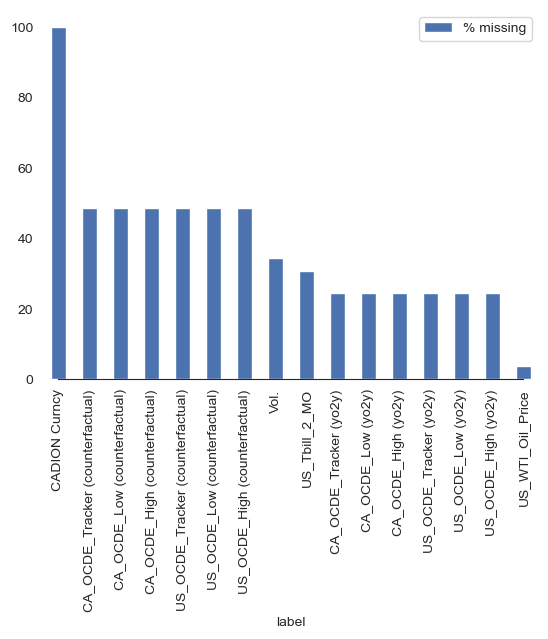

In [446]:
df_missing.plot.bar(color="b")
# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

As such, we have the following strategy to deal with missing data
- Delete CADION Curncy - the overnight forward of FXUSDCAD
- Delete CA_OCDE's and US_OCDE's couterfactual - it's meaning less
- Delete CA_OCDE's and US_OCDE's yo2y - we already have yoy data
- Deleta US 2m T note - already have enough data for 1M - 6M
- Volume of FXUSDCAD - fill by mean before COVID - date: 2020-2-19
- US WTI Oil Price - all on weekend and non-trading day - dropna

Also the US GDP Potential reaches 2030
- so we remove the data after today

In [447]:
# CADION
RawData.list_df_Mkt_data[5] = RawData.list_df_Mkt_data[5].loc[:, RawData.list_df_Mkt_data[5].columns != 'CADION Curncy']
label_daily.remove('CADION Curncy')
# OCDE
RawData.list_df_Econ_data[-7] = RawData.list_df_Econ_data[-7].iloc[:, 0:4]
RawData.list_df_Econ_data[-8] = RawData.list_df_Econ_data[-8].iloc[:, 0:4]
for j in range(5):
    for i in label_weekly:
        if 'yo2y' in i:
            label_weekly.remove(i)
        if 'counterfactual' in i:
            label_weekly.remove(i)
# US T-bill 2Mo
RawData.list_df_Econ_data[6] = RawData.list_df_Econ_data[6].loc[:, RawData.list_df_Econ_data[6].columns != 'US_Tbill_2_MO']
label_daily.remove('US_Tbill_2_MO')
# Volume of FXUSDCAD
volume_list_before_covid = RawData.list_df_Mkt_data[1][RawData.list_df_Mkt_data[1]['date'] <= '2022-02-19']['Vol.'].dropna().values.tolist()
avg_vol_before_covid = round(sum(volume_list_before_covid)/len(volume_list_before_covid), 0)
RawData.list_df_Mkt_data[1].loc[RawData.list_df_Mkt_data[1]['date'] <= '2019-01-17', 'Vol.'] = avg_vol_before_covid
# US WTI Oil Price
RawData.list_df_Econ_data[-14] = RawData.list_df_Econ_data[-14].dropna()
# US GDP Potential
RawData.list_df_Econ_data[10] = RawData.list_df_Econ_data[10][RawData.list_df_Econ_data[10]['date'] <= '2022-11-3']

## Re-merge the data after dealing with NAs in original data

In [539]:
data_mkt_total = Utilities.merge_df(RawData.list_df_Mkt_data)
data_econ_total = Utilities.merge_df(RawData.list_df_Econ_data)
data_total = data_mkt_total.merge(data_econ_total, on='date', how='outer')
data_total = data_total.sort_values(by='date')
data_total = data_total.reset_index().drop(['index'], axis=1)
data_total = data_total[data_total['date'] < '2022-11-04']

## Forward fill the montly, biweekly, quarterly and annually data to match daily frequency and further deal with NAs

In [540]:
# weekdly data
data_total.loc[:, label_weekly] = data_total.loc[:, label_weekly].ffill()

# biweekly data
data_total.loc[:, label_biweekly] = data_total.loc[:, label_biweekly].ffill()
data_total.loc[:, label_biweekly] = data_total.loc[:, label_biweekly].bfill()
data_total.loc[data_total['date'] <= '2022-01-01', ['PCEPILFE', 'US_Sales_RetailFood']] = data_total.loc[data_total['date'] <= '2022-01-01', ['PCEPILFE', 'US_Sales_RetailFood']].ffill()

# monthly data
data_total.loc[data_total['date'] <= '2022-01-01', ['PCEPILFE', 'US_Sales_RetailFood']] = data_total.loc[data_total['date'] <= '2022-01-01', ['PCEPILFE', 'US_Sales_RetailFood']].ffill()
data_total['PCEPILFE'].fillna(data_total['PCEPILFE'].rolling(window=365,min_periods = 7).mean(), inplace = True)
data_total['US_Sales_RetailFood'].fillna(data_total['US_Sales_RetailFood'].rolling(window=365,min_periods = 7).mean(), inplace = True)

data_total.loc[data_total['date'] <= '2022-02-01', ['CPIAUCSL', 'US_Sales_House', 'US_Unemp', 'US_Emp']] = data_total.loc[data_total['date'] <= '2022-01-01', ['CPIAUCSL', 'US_Sales_House', 'US_Unemp', 'US_Emp']].ffill()
data_total['CPIAUCSL'].fillna(data_total['CPIAUCSL'].rolling(window=365,min_periods = 7).mean(), inplace = True)
data_total['US_Sales_House'].fillna(data_total['US_Sales_House'].rolling(window=365,min_periods = 7).mean(), inplace = True)
data_total['US_Unemp'].fillna(data_total['US_Unemp'].rolling(window=365,min_periods = 7).mean(), inplace = True)
data_total['US_Emp'].fillna(data_total['US_Emp'].rolling(window=365,min_periods = 7).mean(), inplace = True)

data_total.loc[data_total['date'] <= '2022-08-01', ['CA_CPI', 'CA_Unemp']] = data_total.loc[data_total['date'] <= '2022-01-01', ['CA_CPI', 'CA_Unemp']].ffill()
data_total['CA_CPI'].fillna(data_total['CA_CPI'].rolling(window=365,min_periods = 7).mean(), inplace = True)
data_total['CA_Unemp'].fillna(data_total['CA_Unemp'].rolling(window=365,min_periods = 7).mean(), inplace = True)

data_total.loc[data_total['date'] <= '2022-10-01', ['US_Rec_Prob', 'US_Inflation', 'US_Inflation_Expct']] = data_total.loc[data_total['date'] <= '2022-01-01', ['US_Rec_Prob', 'US_Inflation', 'US_Inflation_Expct']].ffill()
data_total['US_Rec_Prob'].fillna(data_total['US_Rec_Prob'].rolling(window=365,min_periods = 7).mean(), inplace = True)
data_total['US_Inflation'].fillna(data_total['US_Inflation'].rolling(window=365,min_periods = 7).mean(), inplace = True)
data_total['US_Inflation_Expct'].fillna(data_total['US_Inflation_Expct'].rolling(window=365,min_periods = 7).mean(), inplace = True)

data_total.loc[data_total['date'] <= '2022-4-01', ['ISM_NonManufactureIdx', 'ISM_PurchaseManagerIdx']] = data_total.loc[data_total['date'] <= '2022-01-01', ['ISM_NonManufactureIdx', 'ISM_PurchaseManagerIdx']].ffill()
data_total['ISM_NonManufactureIdx'].fillna(data_total['ISM_NonManufactureIdx'].rolling(window=365,min_periods = 7).mean(), inplace = True)
data_total['ISM_PurchaseManagerIdx'].fillna(data_total['ISM_PurchaseManagerIdx'].rolling(window=365,min_periods = 7).mean(), inplace = True)

# quarterly data
data_total.loc[data_total['date'] <= '2022-7-01', ['CA_RGDP']] = data_total.loc[data_total['date'] <= '2022-7-01', ['CA_RGDP']].ffill()
data_total['CA_RGDP'].fillna(data_total['CA_RGDP'].rolling(window=365,min_periods = 7).mean(), inplace = True)

data_total.loc[data_total['date'] <= '2022-2-01', ['US_RGDP']] = data_total.loc[data_total['date'] <= '2022-2-01', ['US_RGDP']].ffill()
data_total['US_RGDP'].fillna(data_total['US_RGDP'].rolling(window=365,min_periods = 7).mean(), inplace = True)

data_total['US_PGDP'] = data_total['US_PGDP'].ffill()

# annually data
data_total[label_annualy] = data_total[label_annualy].ffill()



In [558]:
# use the previous available value to fill on row with index 3 so we can better handle the data
for label in data_total.columns.values.tolist()[3:]:
    if not pd.notnull(data_total.loc[3, label]):
        for i in range(3):
            if pd.notnull(data_total.loc[i, label]):
                data_total.loc[3, label] = data_total.loc[i, label]
# CA VIX is just one instance, we will backfill use the next day's value
data_total.loc[3, 'CA_VIX'] = data_total.loc[4, 'CA_VIX']

# for the rest, we will fill it use the average value before covid
for label in ["CA_OCDE_Tracker (yoy)", "CA_OCDE_Low (yoy)", "CA_OCDE_High (yoy)", "US_OCDE_Tracker (yoy)", "US_OCDE_Low (yoy)",
              "US_OCDE_High (yoy)", "CA_W.BCPI", "CA_W.BCNE", "CA_W.ENER", "CA_W.MTLS", "CA_W.FOPR", "CA_W.AGRI", "CA_W.FISH"]:
    list_value_before_covid = data_total[data_total['date'] <= '2022-02-19'][label].dropna().values.tolist()
    avg_value_before_covid = sum(list_value_before_covid)/len(list_value_before_covid)
    data_total.loc[data_total['date'] <= '2019-01-17', label] = avg_value_before_covid

data_total = data_total.iloc[3:,:]
data_total.loc[3, 'FXUSDCAD'] = data_total.loc[3, 'Price']
data_total = data_total[data_total['FXUSDCAD'].notna()]
data_total = data_total.ffill()
data_total = data_total.loc[:, data_total.columns != 'Price']

In [582]:
data_total.shape

(1460, 91)

## Here we merge the NLP sentiments with the dataset

In [705]:
df_ca_cleaned = df_ca_cleaned[['date', 'sentiment_score']].rename({'sentiment_score': 'CA_sentiment'}, axis='columns')
df_ca_cleaned['date'] = pd.to_datetime(df_ca_cleaned['date'], format='%Y-%m-%d')
df_us_cleaned = df_us_cleaned[['date', 'sentiment_score']].rename({'sentiment_score': 'US_sentiment'}, axis='columns')
df_us_cleaned['date'] = pd.to_datetime(df_us_cleaned['date'], format='%Y-%m-%d')

In [796]:
df_sentment = df_ca_cleaned.merge(df_us_cleaned, on='date', how='outer').sort_values(by='date')
df_final = data_total.merge(df_sentment, on='date', how='outer').sort_values(by='date')
df_final = df_final.ffill()
df_final = df_final.iloc[2:,:]

## Feature Engineering

### Added features

#### Technical features
1. Bollingerband Indicator: if it reaches high or low band of bb (bb_bbhi, bb_bbli, dummy)
2. RSI indicator: reletive strength index
3. MACD signal

In [743]:
# https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#volatility-indicators
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.trend import MACD

In [797]:
# RSI
indicator_RSI = RSIIndicator(close=df_final["FXUSDCAD"], fillna=False)
df_final['tech_RSI'] = indicator_RSI.rsi()

# BB
indicator_bb = BollingerBands(close=df_final["FXUSDCAD"], fillna=True)
# Add Bollinger Band high indicator
df_final['tech_BB_bbh_ind'] = indicator_bb.bollinger_hband_indicator()
# Add Bollinger Band low indicator
df_final['tech_BB_bbl_ind'] = indicator_bb.bollinger_lband_indicator()

# MACD
indicator_MACD = MACD(close=df_final["FXUSDCAD"], fillna=False)
df_final['tech_MACD_sig'] = indicator_MACD.macd_signal()

#### Economic Sense features
1. Oil and other major index price fluctuation, we will use percetange compare to the base year for long freq data
2. Deviation from Realized vol to implied vol (measures market deviation), realized vol to garch vol (measures deviation from people's expectation)
3. Real GDP US / GDP CA - since FX is a ratio, we will use the GDP ratio to measure it adjusted by FX rate
4. (Real GDP US - Potential GDP US) / Potential GDP US, see how much the GDP is missing the target

In [798]:
index_label = ['SP5', 'S&P/TSX', 'PCEPILFE', 'US_Sales_RetailFood', 'US_Sales_House', 'US_WTI_Oil_Price', 'US_Commodity_Idx',
              'CA_W.BCPI', "CA_W.BCNE", "CA_W.ENER", "CA_W.MTLS", "CA_W.FOPR", "CA_W.AGRI", "CA_W.FISH", "CA_WGTS.AGRI", 
               "CA_WGTS.BRENT", "CA_WGTS.COAL", "CA_WGTS.FISH", "CA_WGTS.FOPR", "CA_WGTS.MTLS", "CA_WGTS.NATURALGAS",
               "CA_WGTS.WCC", "CA_WGTS.WTI", 'ISM_NonManufactureIdx', 'ISM_PurchaseManagerIdx']
for label in ['SP5', 'S&P/TSX', 'US_WTI_Oil_Price', 'US_Commodity_Idx']:
    df_final[label + "pctChange"] = df_final[label].pct_change()
    df_final.drop(label, axis=1, inplace=True)
    
for label in ['PCEPILFE', 'US_Sales_RetailFood', 'US_Sales_House', 'CA_W.BCPI', "CA_W.BCNE", 
              "CA_W.ENER", "CA_W.MTLS", "CA_W.FOPR", "CA_W.AGRI", "CA_W.FISH", "CA_WGTS.AGRI", 
              "CA_WGTS.BRENT", "CA_WGTS.COAL", "CA_WGTS.FISH", "CA_WGTS.FOPR", "CA_WGTS.MTLS", 
              "CA_WGTS.NATURALGAS", "CA_WGTS.WCC", "CA_WGTS.WTI", 'ISM_NonManufactureIdx', 
              'ISM_PurchaseManagerIdx', 'US_M2']:
    df_final[label + "pctChangeBase"] = df_final[label].astype(float) / float(df_final[label].values[0]) - 1
    df_final.drop(label, axis=1, inplace=True)
    
# scaling US_Employment rate
df_final['US_Emp'] = df_final['US_Emp'] / 100000

In [799]:
# New Vol Params
df_final['Vol_1W_Impl_Real'] = df_final['USDCADV1W Curncy'] - df_final['USDCADH1W BGN Curncy']
df_final['Vol_2W_Impl_Real'] = df_final['USDCADV2W Curncy'] - df_final['USDCADH2W BGN Curncy']
df_final['Vol_1M_Impl_Real'] = df_final['USDCADV1M BGN Curncy'] - df_final['USDCADH1M BGN Curncy']

df_final['Vol_1W_Real_Garch'] = df_final['USDCADH1W BGN Curncy'] - df_final['USDCADG1W Curncy']
df_final['Vol_2W_Real_Garch'] = df_final['USDCADH2W BGN Curncy'] - df_final['USDCADG2W Curncy']
df_final['Vol_1M_Real_Garch'] = df_final['USDCADH1M BGN Curncy'] - df_final['USDCADG1M Curncy']

# GDP ratio
df_final['US_RGDP'] = df_final['US_RGDP'] / 1000
df_final['US_PGDP'] = df_final['US_PGDP'] / 1000
df_final['CA_RGDP'] = df_final['CA_RGDP'] / 1e+11
df_final['Econ_GDP_UStoCA'] = df_final['US_RGDP'] * df_final['FXUSDCAD'] / df_final['CA_RGDP']
df_final['Econ_GDP_US_RtoP'] = (df_final['US_RGDP'] - df_final['US_PGDP']) / df_final['US_PGDP']



In [800]:
df_final = df_final.set_index('date')
df_final = df_final.drop(columns=['Open', 'High', 'Low', 'Change %'])

In [801]:
df_final.to_csv("../data/dataset/df_final.csv")

#### Autoregressive parameters 

first, we check the distribution of the parameters and see if anything can be log transformed

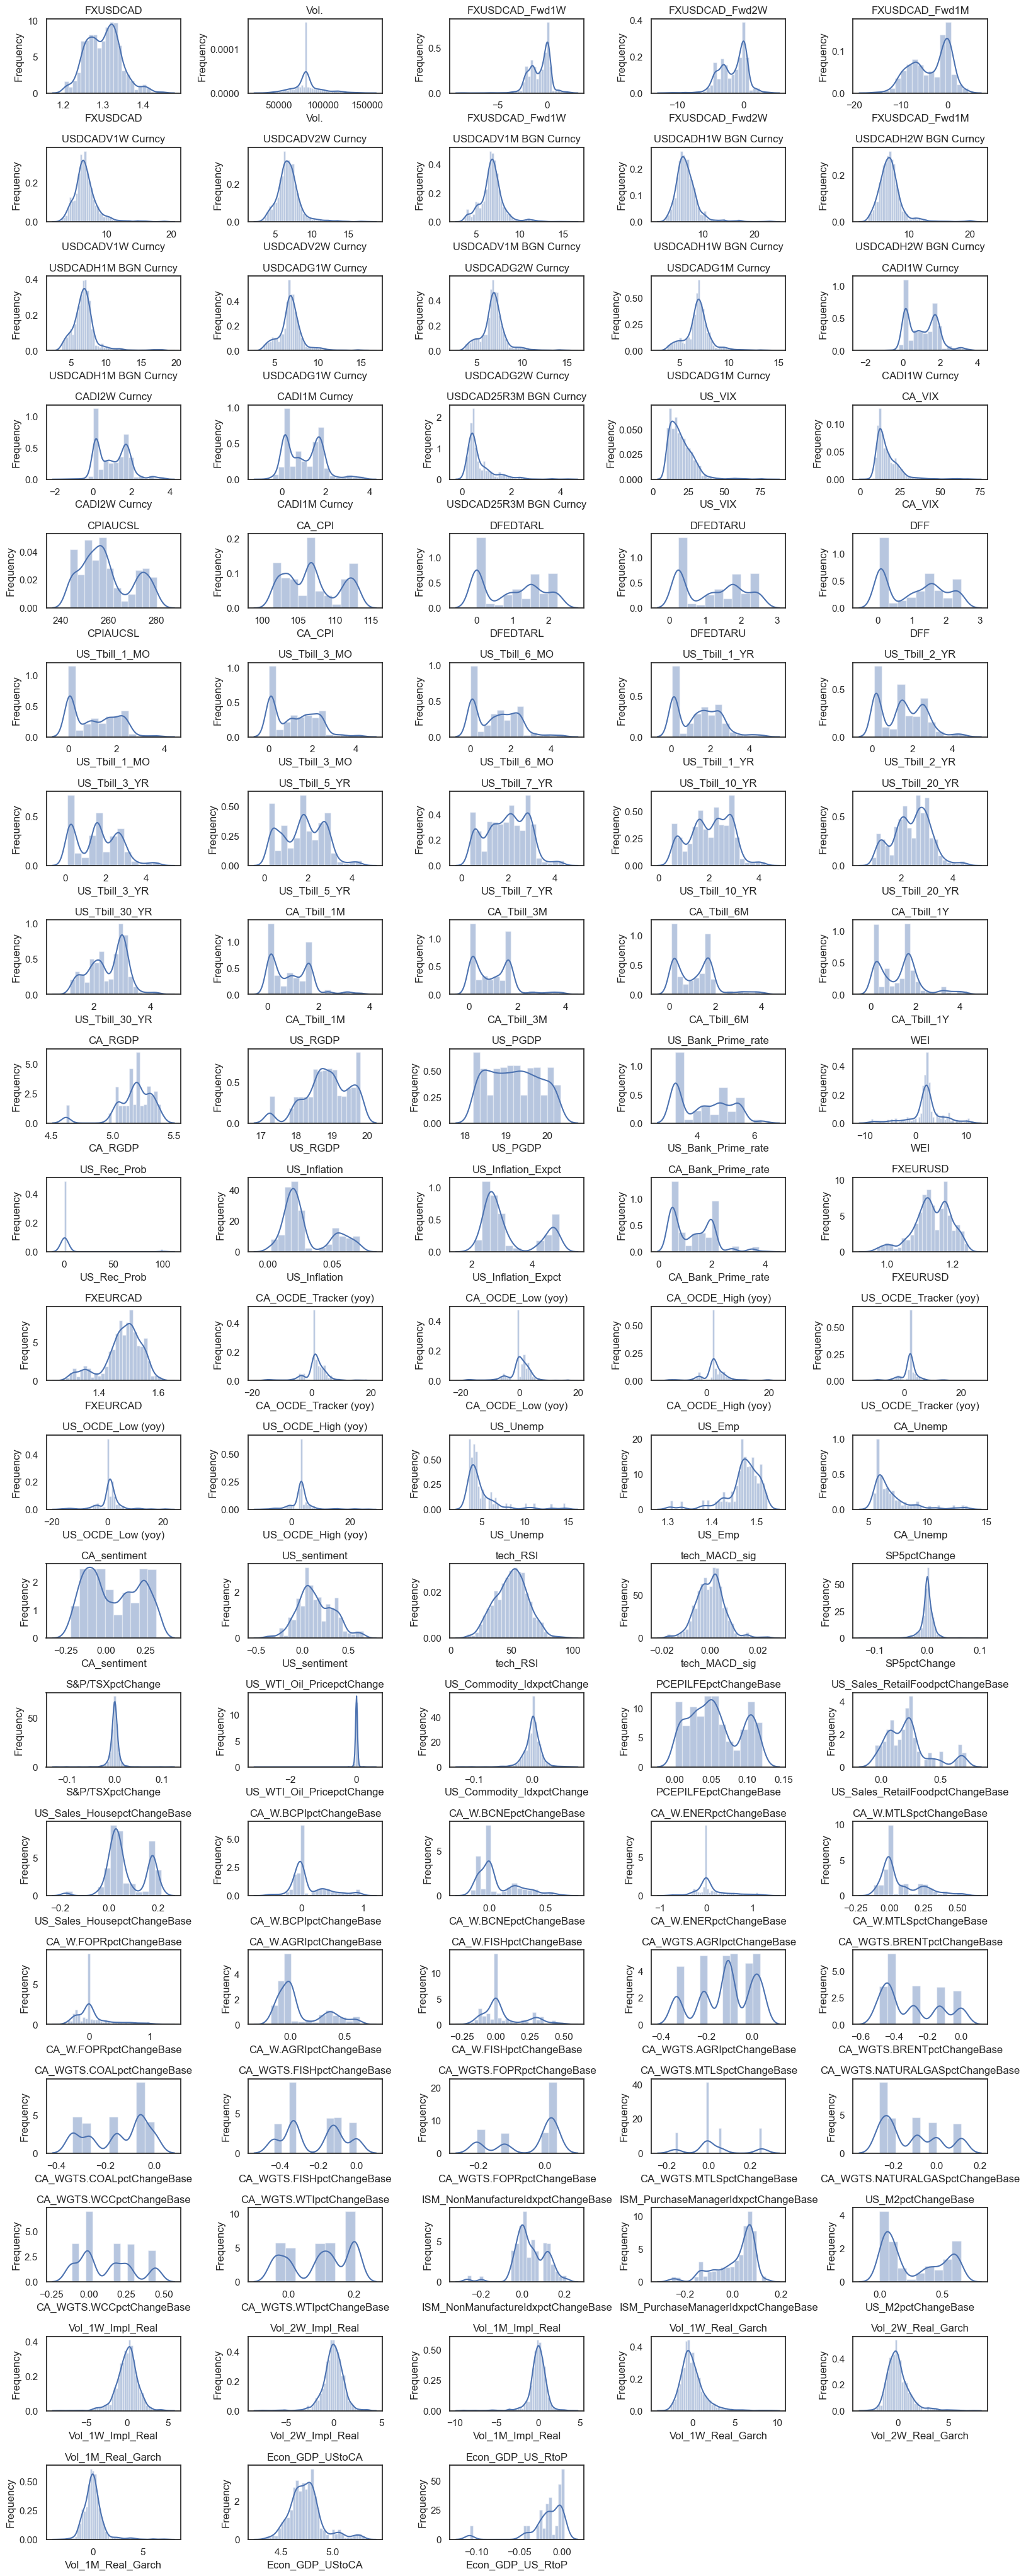

In [786]:
# check the dist plot of the parameter
fig = plt.figure(figsize=(16, 200))
sns.set_style("white")
sns.set_color_codes(palette='deep')
for idx, label in enumerate(df_final.columns.values[:-4]):
    ax = plt.subplot(len(df_final.columns.values[:-4]), 5, idx + 1)
    sns.distplot(df_final[label],color = "b")
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

In [787]:
# Skew and kurt
for label in df_final.columns.values[:-4]:
    print(label + " 's skew and kurt:")
    print("Skewness: %f" % df_final[label].skew())
    print("Kurtosis: %f\n" % df_final[label].kurt())

FXUSDCAD 's skew and kurt:
Skewness: 0.284222
Kurtosis: 0.088984

Vol. 's skew and kurt:
Skewness: 0.665284
Kurtosis: 1.507920

FXUSDCAD_Fwd1W 's skew and kurt:
Skewness: -0.741005
Kurtosis: 2.696987

FXUSDCAD_Fwd2W 's skew and kurt:
Skewness: -0.618324
Kurtosis: 0.709656

FXUSDCAD_Fwd1M 's skew and kurt:
Skewness: -0.358381
Kurtosis: -0.995777

USDCADV1W Curncy 's skew and kurt:
Skewness: 1.969033
Kurtosis: 7.970472

USDCADV2W Curncy 's skew and kurt:
Skewness: 1.635337
Kurtosis: 6.655900

USDCADV1M BGN Curncy 's skew and kurt:
Skewness: 1.120038
Kurtosis: 4.823005

USDCADH1W BGN Curncy 's skew and kurt:
Skewness: 2.453594
Kurtosis: 11.381397

USDCADH2W BGN Curncy 's skew and kurt:
Skewness: 2.540441
Kurtosis: 11.897200

USDCADH1M BGN Curncy 's skew and kurt:
Skewness: 2.446144
Kurtosis: 10.886079

USDCADG1W Curncy 's skew and kurt:
Skewness: 1.494861
Kurtosis: 6.695040

USDCADG2W Curncy 's skew and kurt:
Skewness: 1.312309
Kurtosis: 5.864600

USDCADG1M Curncy 's skew and kurt:
Skewne

In [2]:
# df_final = pd.read_csv("../data/dataset/df_final.csv")
# df_final['date'] = pd.to_datetime(df_final['date'], format='%Y-%m-%d')
# df_final = df_final.set_index('date')

In [3]:
# We decide to log transform the following parameter
log_labels = ['FXUSDCAD', 'USDCADV1W Curncy', 'USDCADV2W Curncy', 'USDCADV1M BGN Curncy', 'USDCADH1W BGN Curncy',
               'USDCADH2W BGN Curncy', 'USDCADH1M BGN Curncy', 'USDCADG1W Curncy', 'USDCADG2W Curncy', 'USDCADG1M Curncy',
               'US_VIX', 'CA_VIX','FXEURUSD', 'FXEURCAD']
for label in log_labels:
    df_final[label + "_log"] = np.log(df_final[label])
df_final = df_final.drop(log_labels, axis = 1)

In [4]:
# get dummy variable
df_final = pd.get_dummies(df_final, columns=['tech_BB_bbh_ind', 'tech_BB_bbl_ind'])
df_final.to_csv("../data/dataset/df_final_log_dummy.csv")

In [5]:
# now we test the stationary for each columns except the dummmies
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

In [6]:
result = sm.tsa.stattools.adfuller(df_final['FXUSDCAD_log'].values)
print("logged price")
print("ADF Statistic: %f" % result[0])
print("p-value %f\n" % result[1])
print("=" * 30)

result = sm.tsa.stattools.adfuller(np.exp(df_final['FXUSDCAD_log'].values))
print("=" * 30)
print("unlogged price")
print("ADF Statistic: %f" % result[0])
print("p-value %f\n" % result[1])

logged price
ADF Statistic: -2.308233
p-value 0.169326

unlogged price
ADF Statistic: -2.302140
p-value 0.171279



there is no stationarity in the model and we don't use ARIMA

In [7]:
df_final = df_final.dropna()

#### then we will run PCA and see the explainatory of each variable


In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Text(0, 0.5, 'cumulative explained variance')

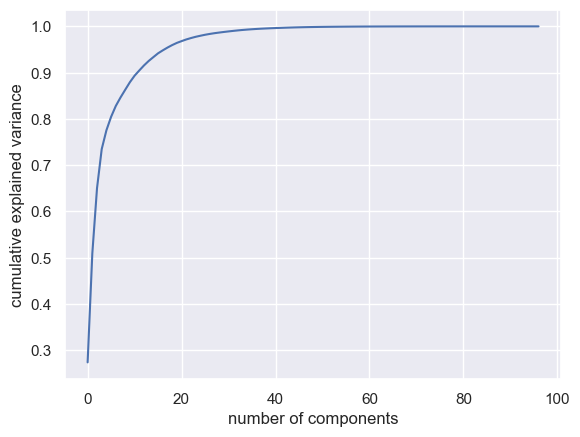

In [18]:
sns.set()
x = df_final.loc[:, df_final.columns.values.tolist()[1:-4]]
x = StandardScaler().fit_transform(x)
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [19]:
pca.explained_variance_ratio_

array([2.73362504e-01, 2.35555463e-01, 1.41141884e-01, 8.44795638e-02,
       4.07083866e-02, 2.91916149e-02, 2.34927866e-02, 1.82481062e-02,
       1.67103941e-02, 1.63772973e-02, 1.40890138e-02, 1.12958087e-02,
       1.08577748e-02, 9.67334603e-03, 8.35111898e-03, 8.22441399e-03,
       6.37811059e-03, 5.98253511e-03, 5.41857384e-03, 4.73597823e-03,
       3.80619981e-03, 3.61876383e-03, 3.02323699e-03, 2.72075291e-03,
       2.26145550e-03, 2.13923654e-03, 1.80621939e-03, 1.60231480e-03,
       1.35842812e-03, 1.28699243e-03, 1.20010480e-03, 1.14088455e-03,
       1.05747370e-03, 9.56151559e-04, 8.34204610e-04, 7.17509994e-04,
       6.59455989e-04, 5.67090297e-04, 4.86828470e-04, 4.52365674e-04,
       3.94594379e-04, 3.66466029e-04, 3.63161582e-04, 3.24877109e-04,
       3.02774205e-04, 2.60042842e-04, 2.42824221e-04, 1.97048343e-04,
       1.80507070e-04, 1.64641964e-04, 1.36298771e-04, 1.14218033e-04,
       1.10345805e-04, 9.41926596e-05, 8.15536081e-05, 8.11102078e-05,
      

<AxesSubplot:>

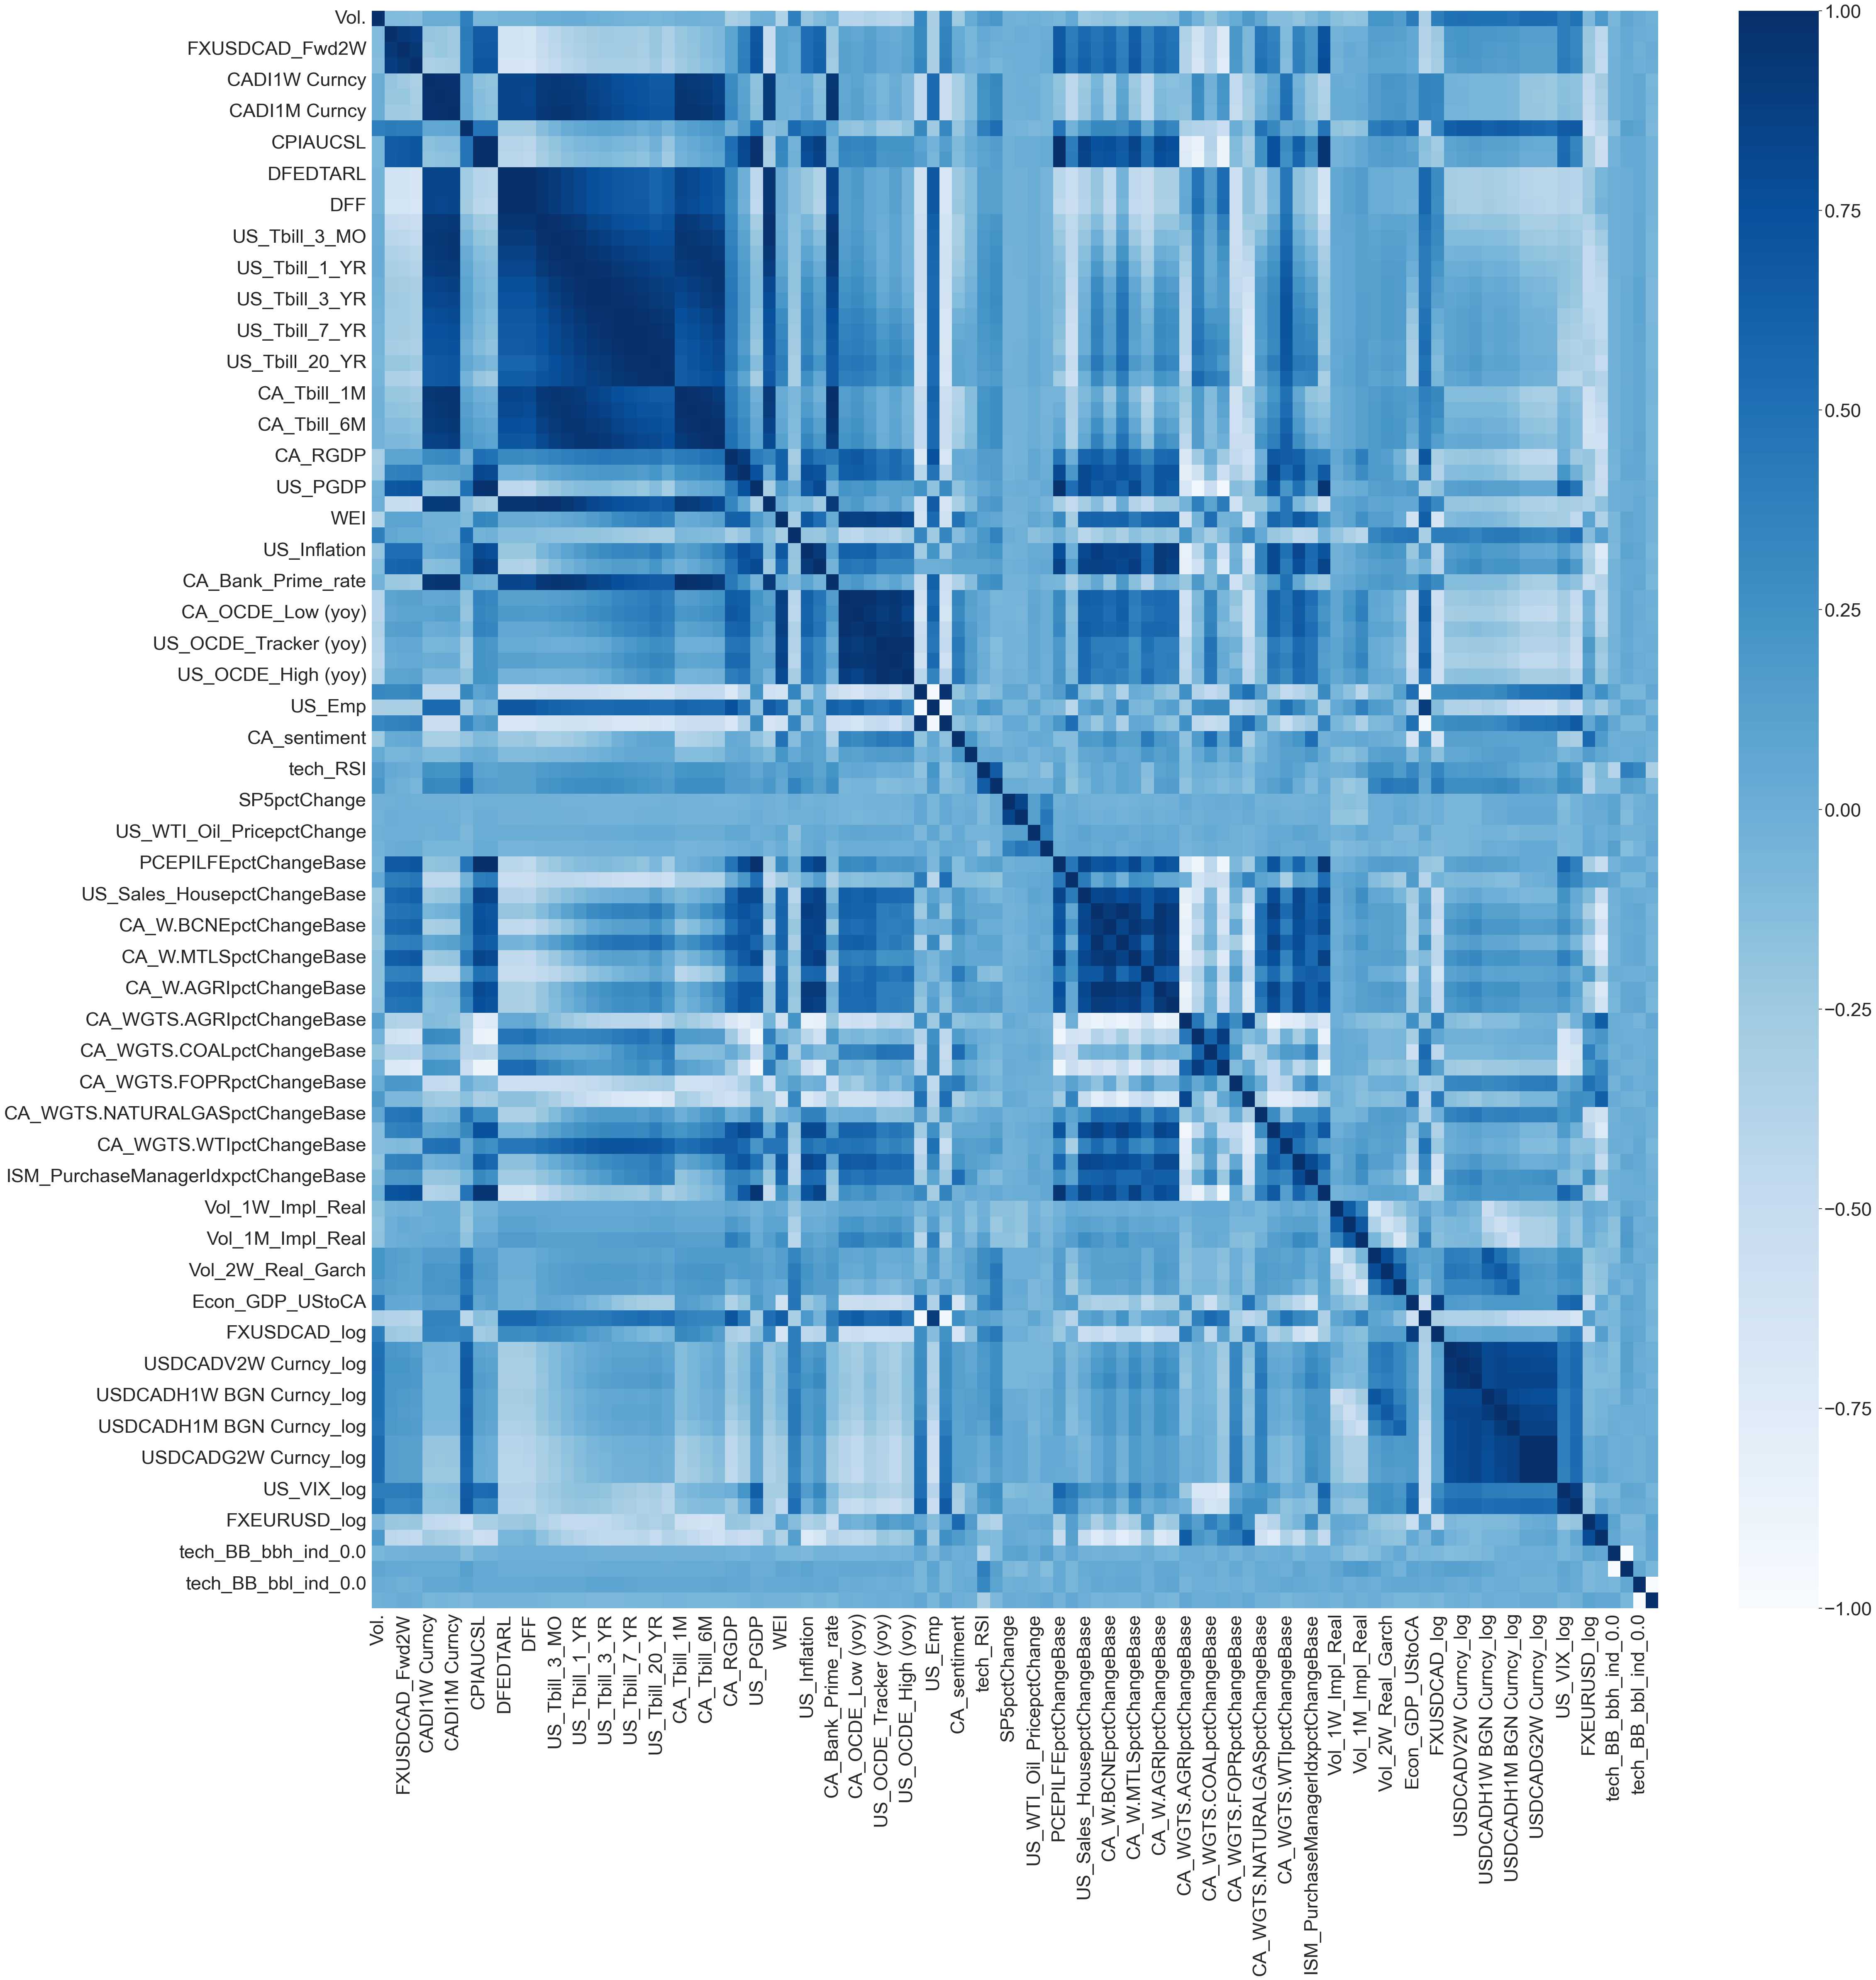

In [30]:
# correlation of the data
sns.set(font_scale=3)
plt.figure(figsize= (50 , 50))
sns.heatmap(df_final.corr(),cmap="Blues")

## Now the data is cleaned, we can run the model

The following model is tested
1. Light Gradient Boost
2. xgboost
3. Ridge Regression
4. Support Vector Machine
5. Gradient Boost Regressor
6. Stacking Cross Validation Regressor on 1-5

In [8]:
#for validation
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from patsy import dmatrix


# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

#### Split train and test

In [ ]:
# Direct read in saved cleaned data
# df_final = pd.read_csv("../data/dataset/df_final_log_dummy.csv")
# df_final['date'] = pd.to_datetime(df_final['date'], format='%Y-%m-%d')
# df_final = df_final.set_index('date')

In [9]:
#split X train X test, Y train, Y test
df_test = df_final.copy()
df_test['FXUSDCAD_log'] = df_test['FXUSDCAD_log'].shift(-14)  # forecasting 14 days after
df_test = df_test.dropna()
x, y = df_test.loc[:, df_test.columns != 'FXUSDCAD_log'], df_test.loc[:, 'FXUSDCAD_log']
X_train, X_test = x[x.index <= '2022-04-18'], x[x.index > '2022-04-18']  # we shift -14, so the last index of FXUSDCAD before 1May2022 is 18Apr2022
Y_train, Y_test = y[y.index <= '2022-04-18'], y[y.index > '2022-04-18']

#### Define models

In [10]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X, Y):
    rmse = np.sqrt(-cross_val_score(model, X, Y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [11]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

#### Train model

In [59]:
# get the cross validation score of each model
scores = {}

score = cv_rmse(lightgbm, X_train, Y_train)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] featu

In [60]:
score = cv_rmse(xgboost, X_train, Y_train)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[22:29:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[22:29:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[22:29:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[22:29:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[22:29:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscal

In [61]:
score = cv_rmse(svr, X_train, Y_train)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.0076 (0.0005)


In [62]:
score = cv_rmse(ridge, X_train, Y_train)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.0095 (0.0007)


In [63]:
score = cv_rmse(rf, X_train, Y_train)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.0052 (0.0007)


In [64]:
score = cv_rmse(gbr, X_train, Y_train)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.0043 (0.0003)


In [66]:
scores

{'lgb': (0.004413377819789325, 0.00037135564164761755),
 'xgb': (0.03309738979653848, 0.0018755240019216915),
 'svr': (0.00764324055036895, 0.0004548501963508966),
 'ridge': (0.00945959360825192, 0.0006829059898761561),
 'rf': (0.00523130576094566, 0.0006767492907951981),
 'gbr': (0.0042611692358081425, 0.00033035623703610593)}

#### Fit the model

In [12]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(Y_train))
print('lightgbm')
lgb_model = lightgbm.fit(np.array(X_train), np.array(Y_train))
print('xgboost')
xgb_model = xgboost.fit(np.array(X_train), np.array(Y_train))
print('Svr')
svr_model = svr.fit(np.array(X_train), np.array(Y_train))
print('Ridge')
ridge_model = ridge.fit(np.array(X_train), np.array(Y_train))
print('RandomForest')
rf_model = rf.fit(np.array(X_train), np.array(Y_train))
print('GradientBoosting')
gbr_model = gbr.fit(np.array(X_train), np.array(Y_train))

stack_gen
[00:32:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cp

#### Blend models and get predictions

In [71]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * ridge_model.predict(X)) + \
            (0.125 * svr_model.predict(X)) + \
            (0.15 * gbr_model.predict(X)) + \
            (0.1 * xgb_model.predict(X)) + \
            (0.15 * lgb_model.predict(X)) + \
            (0.125 * rf_model.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))

In [72]:
# Get final precitions from the blended model
blended_score = rmsle(Y_train, blended_predictions(X_train))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.011591199903569495


#### Identify the best performing model


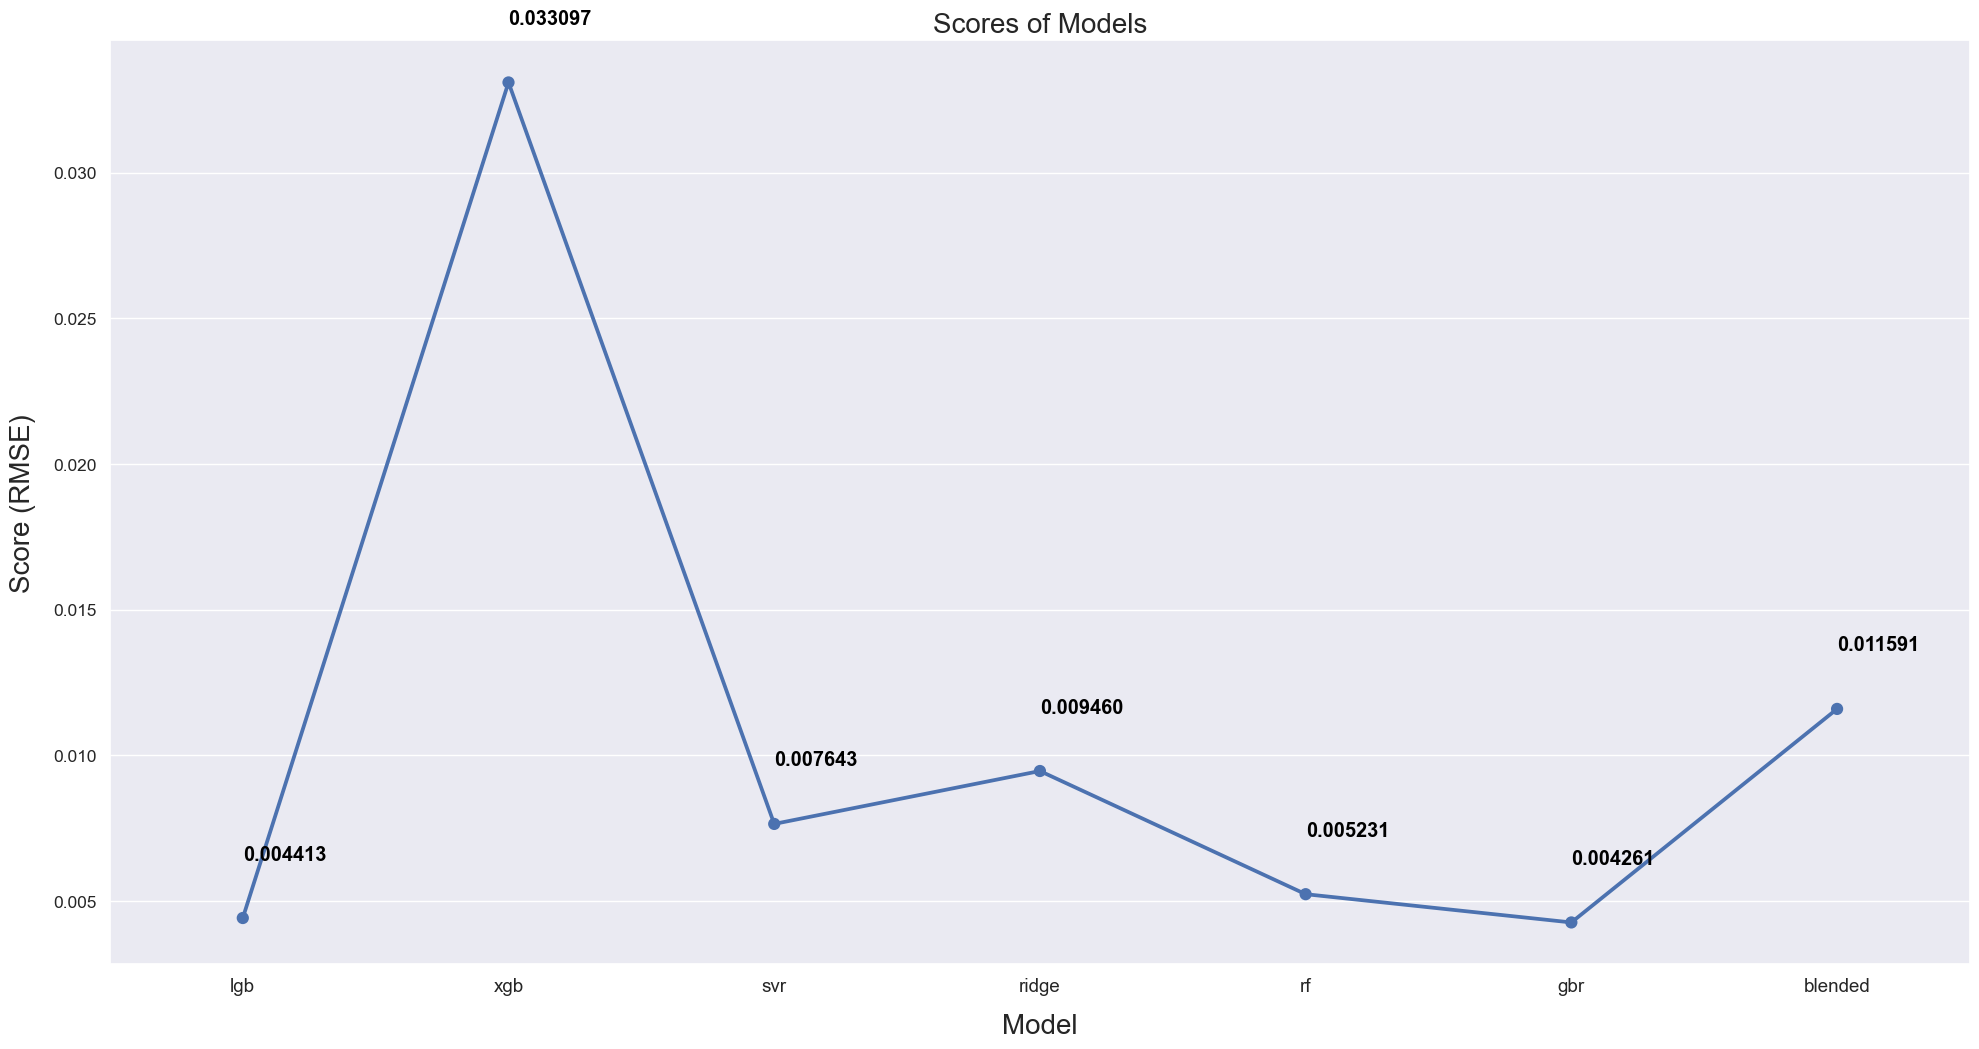

In [74]:
# Plot the predictions for each model
sns.set_style("white")
sns.set(font_scale=1)

fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

#### Let's try the blended model with only lgb abd gbr, which obviously outperform the others

In [76]:
stack_gen_new = StackingCVRegressor(regressors=(lightgbm, gbr),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

print('stack_gen new')
stack_gen_model_new = stack_gen_new.fit(np.array(X_train), np.array(Y_train))

stack_gen new
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [

In [77]:
def blended_predictions_new(X):
    return ((0.2 * gbr_model.predict(X)) + \
            (0.2 * lgb_model.predict(X)) + \
            (0.4 * stack_gen_model_new.predict(np.array(X))))

blended_score_new = rmsle(Y_train, blended_predictions_new(X_train))
scores['blended_new'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score_new)

RMSLE score on train data:
0.05566986313636488


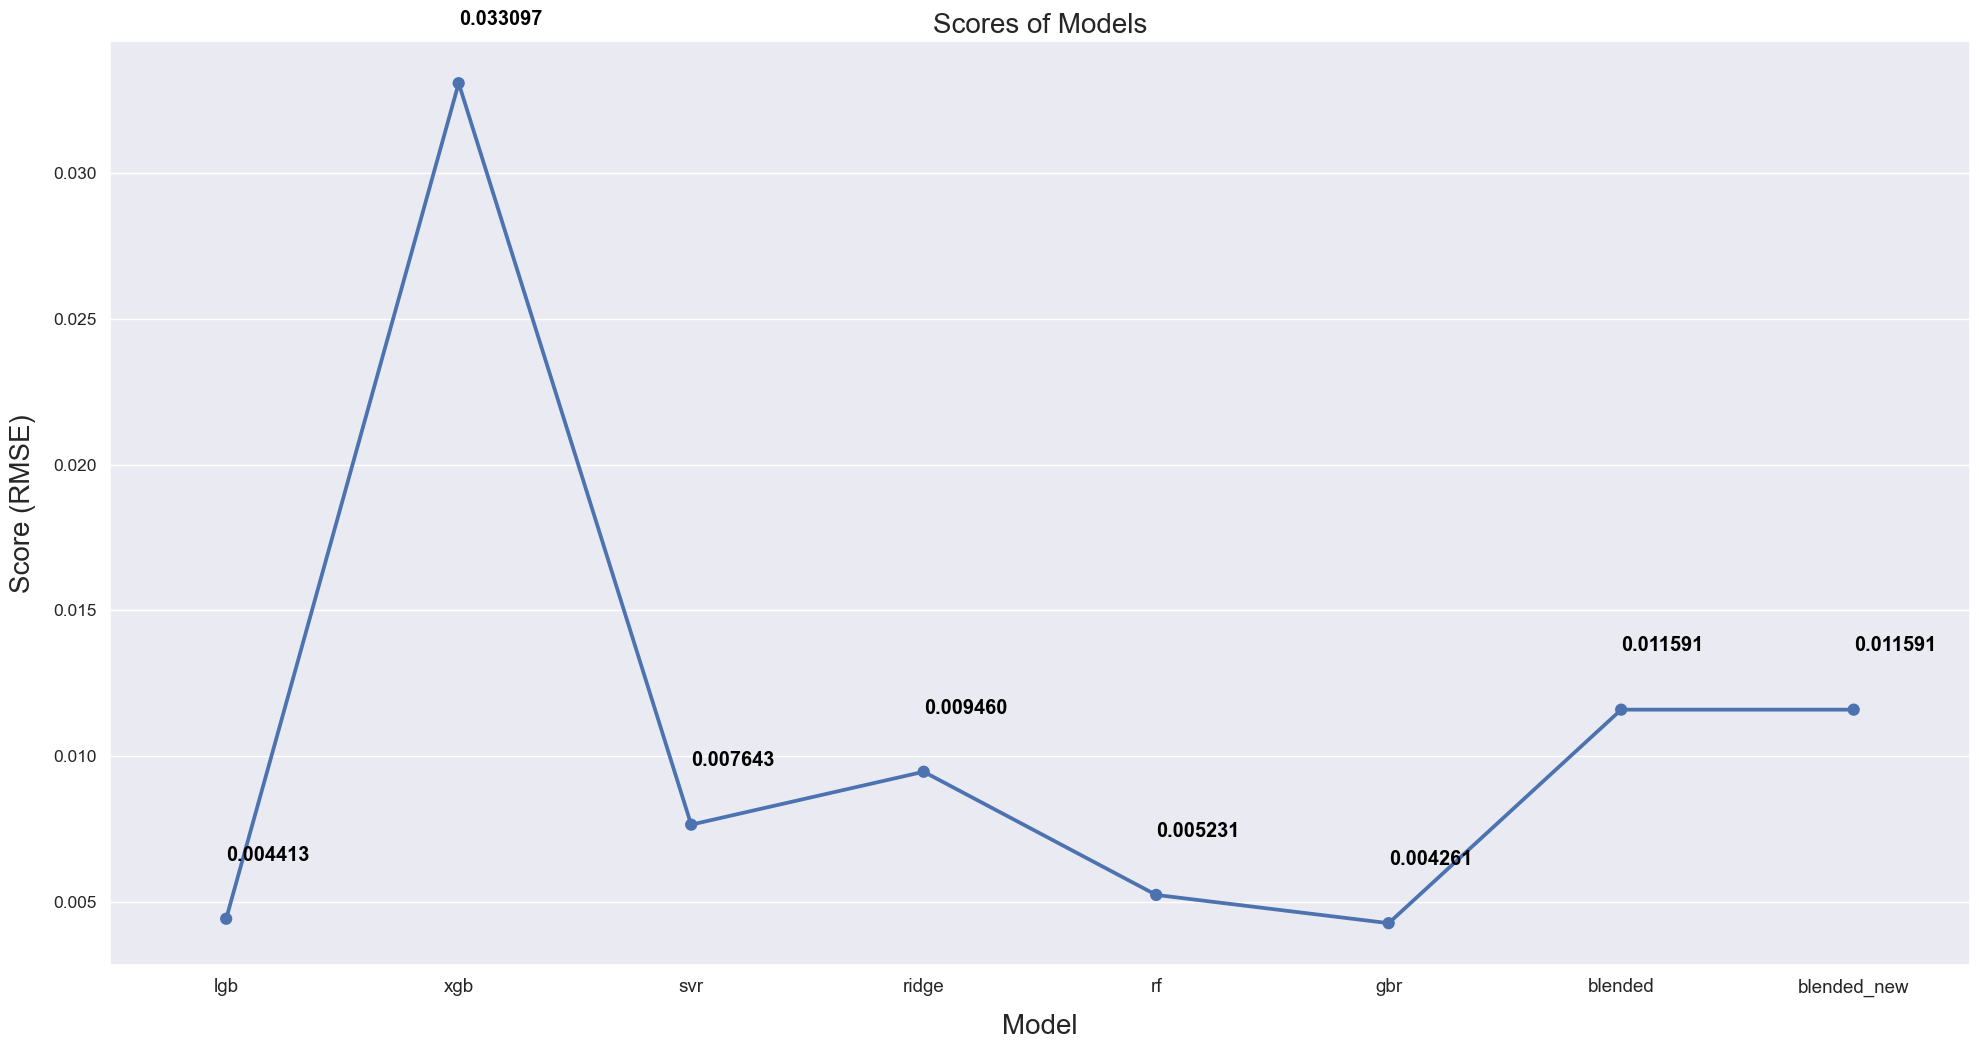

In [78]:
# Plot the predictions for each model
sns.set_style("white")
sns.set(font_scale=1)

fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

#### Out of Sample
Thus, our final model choise will be either gbr or lgb, since we log transfored y, now we exponential it back

In [13]:
scores_out_of_sample = {}

gbr_test_score = rmsle(np.exp(Y_test), np.exp(gbr_model.predict(X_test)))
scores_out_of_sample['Gradient Boosting Regressor'] = gbr_test_score
print('RMSLE score on test data for gbr:')
print(gbr_test_score)

lgb_test_score = rmsle(np.exp(Y_test), np.exp(lgb_model.predict(X_test)))
scores_out_of_sample['Light Radient Boost'] = lgb_test_score
print('RMSLE score on test data for lgb:')
print(lgb_test_score)

RMSLE score on test data for gbr:
0.03944518148381568
RMSLE score on test data for lgb:
0.03365720932808133


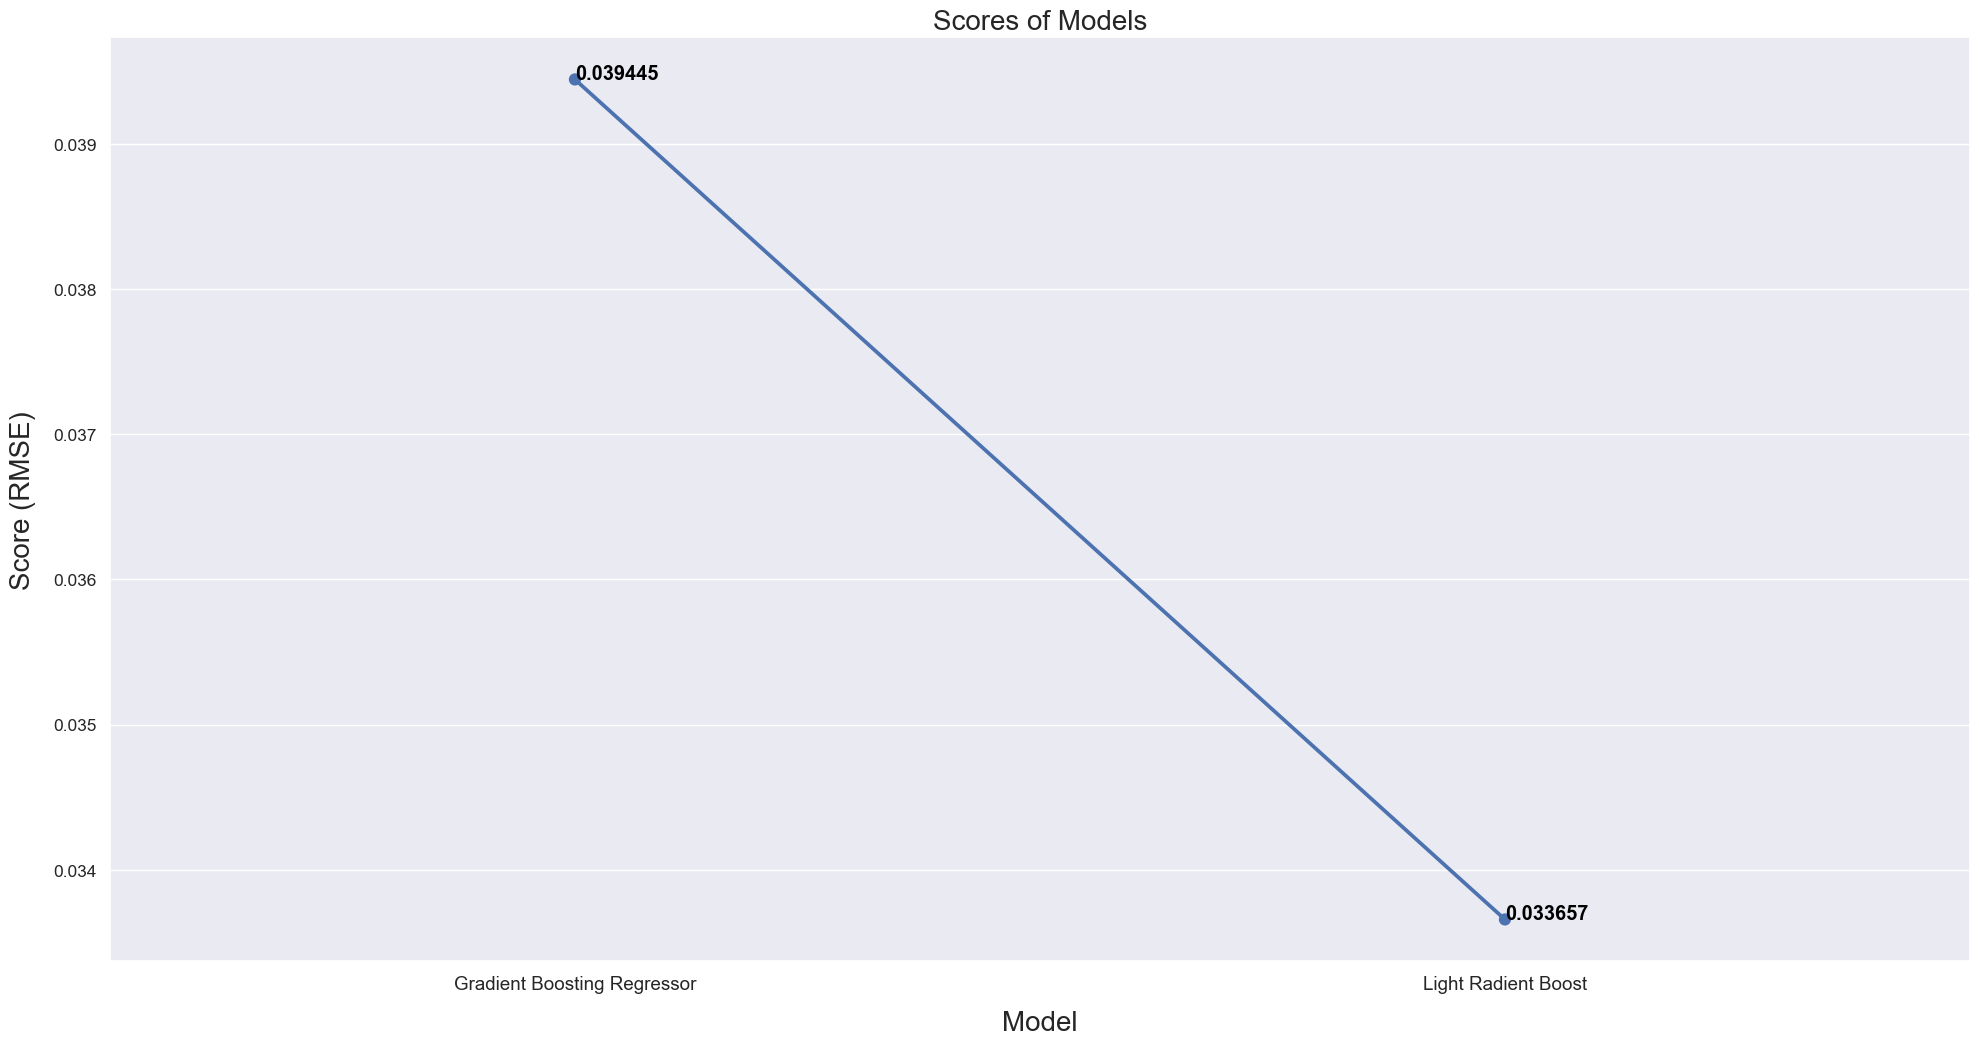

In [14]:
# Plot the predictions for out of sample testing
sns.set_style("white")
sns.set(font_scale=1)

fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores_out_of_sample.keys()), y=[score for score in scores_out_of_sample.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores_out_of_sample.values()):
    ax.text(i, score, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

## The final model gives an out of sample RMSE 0.033657